### 2. Tree-Based Methods

(a)

In [1]:
import numpy as np
import pandas as pd

df_tr = pd.read_csv(r'../data/aps_failure_training_set.csv', skiprows = 20, na_values = 'na')
df_te = pd.read_csv(r'../data/aps_failure_test_set.csv', skiprows = 20, na_values = 'na')

print('The shape of training set is:', df_tr.shape)
print('Total number of NaN in training set: ', df_tr.isna().sum().sum())
print('The shape of test set is:', df_te.shape)
print('Total number of NaN in test set: ', df_te.isna().sum().sum())

The shape of training set is: (60000, 171)
Total number of NaN in training set:  850015
The shape of test set is: (16000, 171)
Total number of NaN in test set:  228680


(b)

i.  common imputation methods: mean imputation, substitution, hot/cold deck imputation, regression imputation, etc.<br>
        I will use simple median substitution for this dataset

In [2]:
from sklearn.impute import SimpleImputer

X_tr = df_tr.drop(['class'], axis = 1)
X_te = df_te.drop(['class'], axis = 1)
y_train = df_tr['class']
y_test = df_te['class']


# fit imputer on training data
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'median')
imp_mean.fit(X_tr)

# impute missing values in both training and test set
X_train = pd.DataFrame(data = imp_mean.transform(X_tr), index = X_tr.index, columns = X_tr.columns)
X_test = pd.DataFrame(data = imp_mean.transform(X_te), index = X_te.index, columns = X_te.columns)

print('Total number of NaN in imputed training set: ', X_train.isna().sum().sum())
print('Total number of NaN in imputed test set: ', X_test.isna().sum().sum())

Total number of NaN in imputed training set:  0
Total number of NaN in imputed test set:  0


ii.

In [3]:
from sklearn.preprocessing import Normalizer

# columns with zeros will end up being picked in part iv. with raw data, had to come back and normalize dataset
#X_train_nor = pd.DataFrame(data = Normalizer().fit_transform(X_train), index = X_train.index, columns = X_train.columns)

# compute coeffcient of variation CV
cv = X_train.apply(lambda x: np.std(x)/np.mean(x), axis = 0).sort_values(ascending=False)
cv

cf_000    244.885476
co_000    244.505347
ad_000    244.320780
cs_009    237.928571
dh_000    123.215070
             ...    
bo_000      0.792376
bp_000      0.753385
bq_000      0.718528
br_000      0.689106
cd_000      0.000000
Length: 170, dtype: float64

iii.

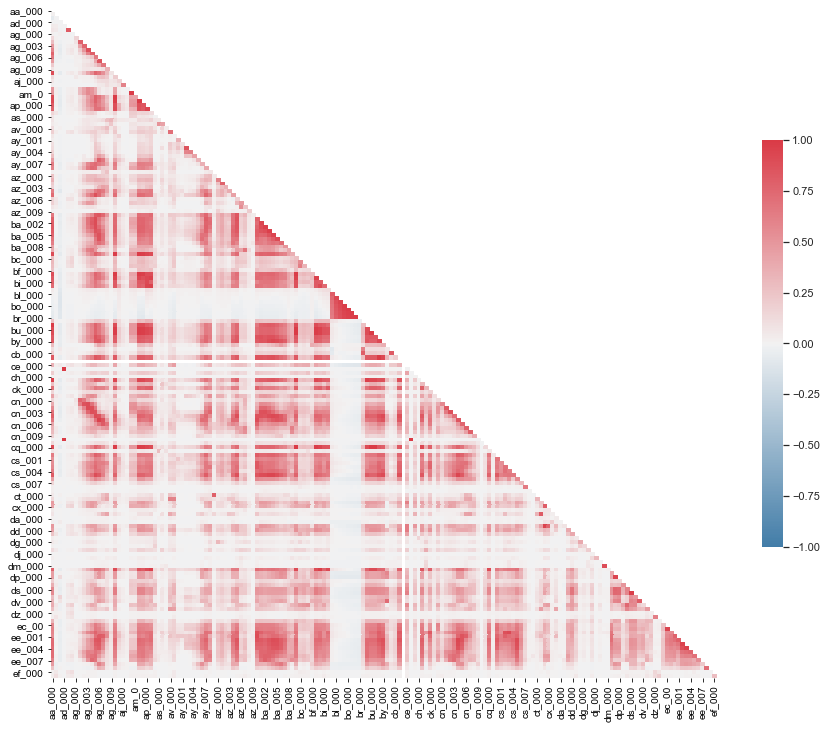

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# compute correlation matrix of features
corr = X_train.corr()

# plot heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(240, 10, as_cmap = True)
sns.set(font_scale = 1)
sns.heatmap(corr, mask = mask, cmap = cmap, vmin = -1, vmax = 1, center = 0, square = True,
            xticklabels = 'auto', yticklabels = 'auto', linewidths = 0, cbar_kws={'shrink': 0.5}).set_facecolor('white')

iv.

In [5]:
import math

high_cv = cv.nlargest(n = math.floor(math.sqrt(170))).index
high_cv # pick ⌊√170⌋ features with highest CV

Index(['cf_000', 'co_000', 'ad_000', 'cs_009', 'dh_000', 'dj_000', 'ag_000',
       'as_000', 'ay_009', 'ak_000', 'az_009', 'ch_000', 'au_000'],
      dtype='object')

D:\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
D:\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


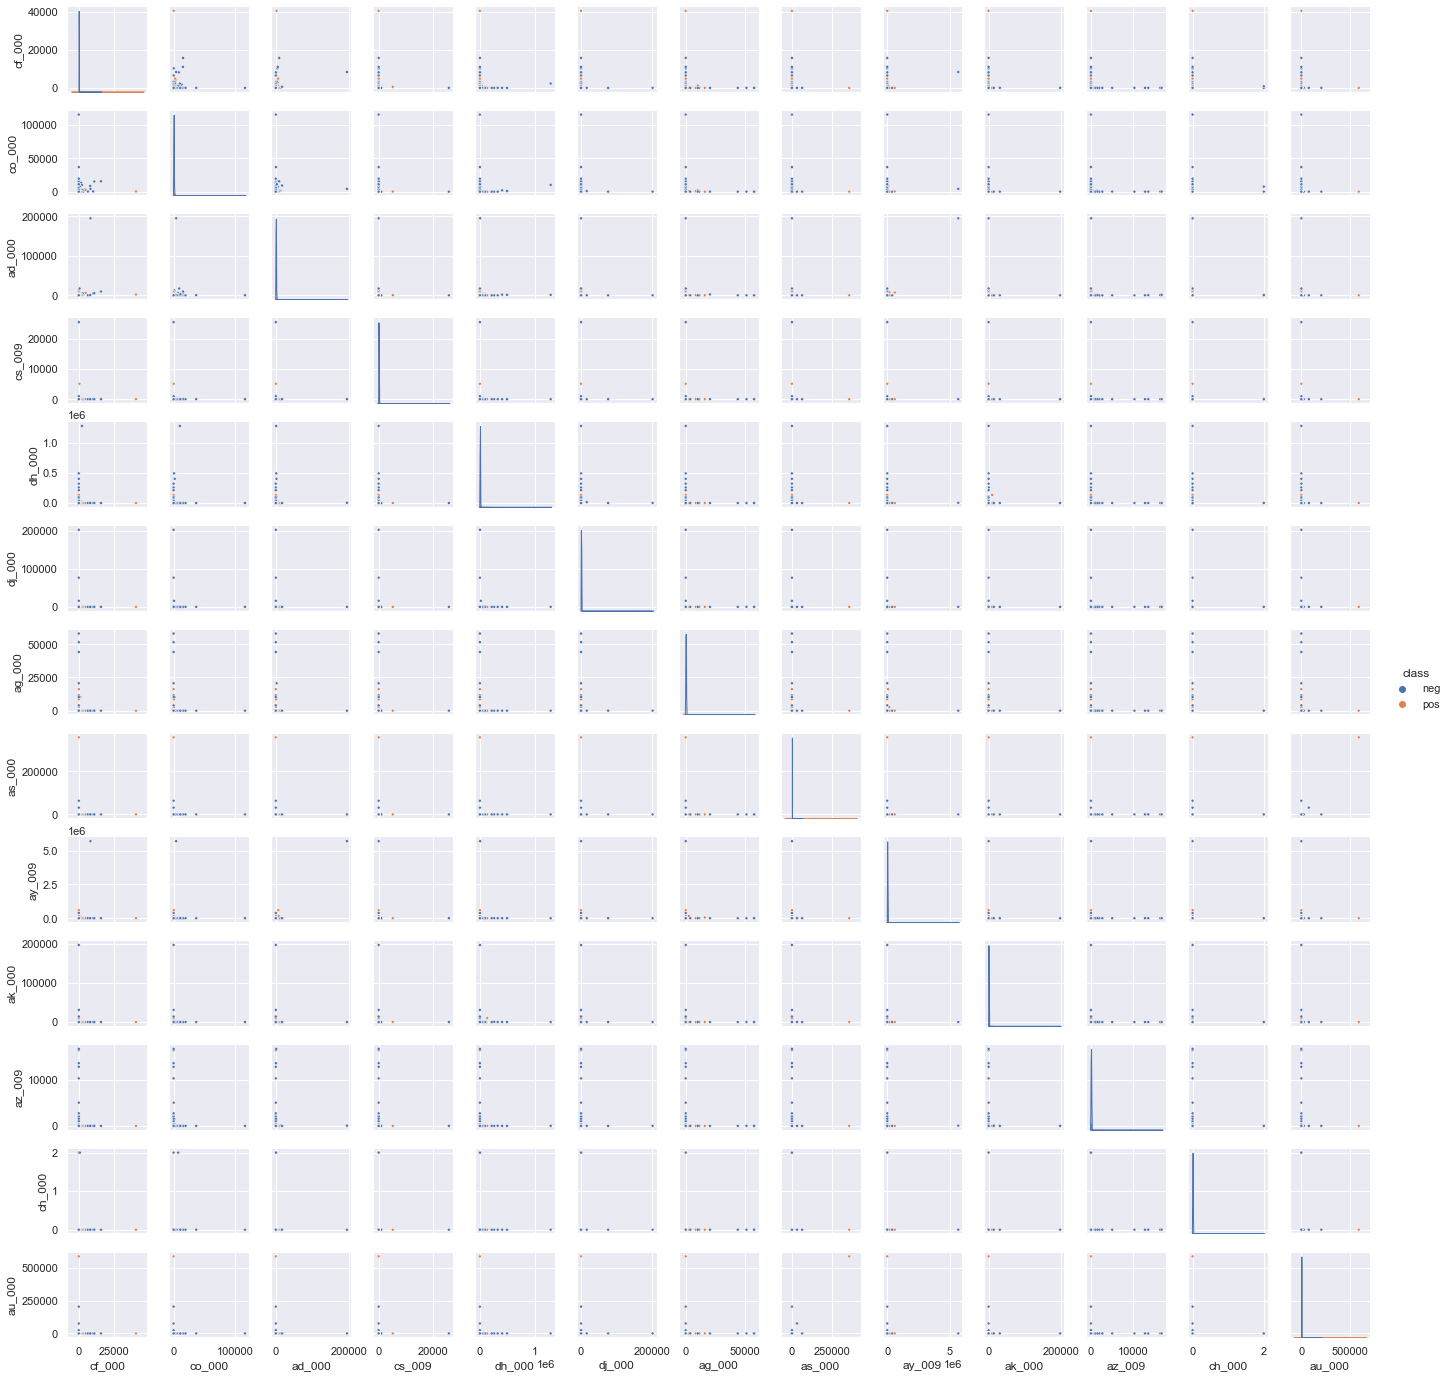

In [6]:
# create a dataframe for visualization
stats_df = X_train[high_cv]
stats_df = stats_df.join(y_train)

# create pairplot
sns.pairplot(stats_df.sample(frac=0.1), vars = high_cv, hue = 'class', markers = '.', height = 1.5)

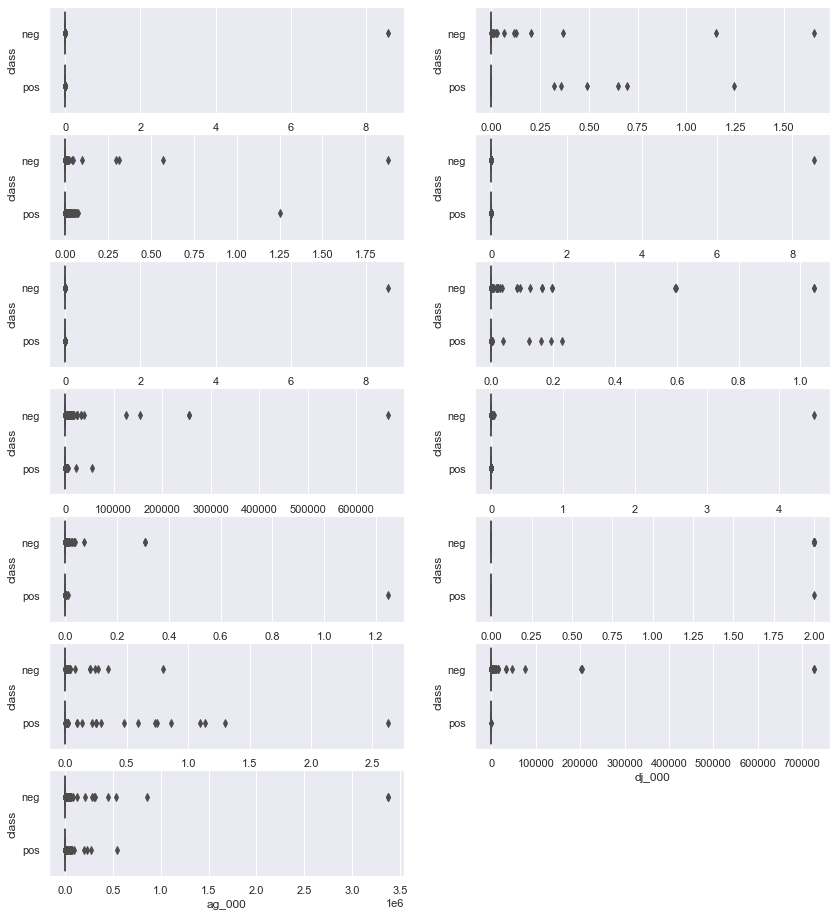

In [7]:
# create boxplot for each feature
fig, axes = plt.subplots(7, 2)
fig.set_size_inches(14,16)
for i,t in enumerate(high_cv):
    sns.boxplot(data=stats_df, x=t, y = 'class', ax = axes[i % 7, i % 2])
fig.delaxes(axes[6][1])

cannot draw any conclusions about the significance of the features due to data imbalance

v.

In [8]:
df_tr['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

this dataset is heavily imbalanced

(c)

             Predicted: NO  Predicted: YES
Actual: NO           15604              21
Actual: YES            104             271 

test error: 0.9921875
Missclassification: 0.0078125
AUC: 0.9942276266666666
Out of Bag error: 0.994


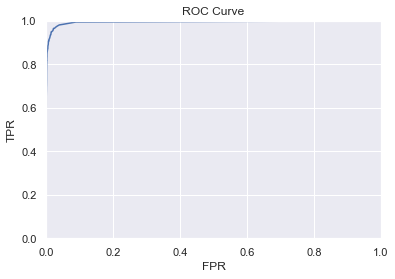

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

# fit random forest model
m_rf = RandomForestClassifier(oob_score = True).fit(X_train, y_train)
y_pred = m_rf.predict(X_test)

# calculate and plot ROC
y_test_bi = LabelBinarizer().fit_transform(y_test)

y_pred_prob = m_rf.predict_proba(X_test)[:, 1]
fp, tp, thresholds = metrics.roc_curve(y_test_bi, y_pred_prob)

plt.plot(fp, tp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

# report model scores
mat = confusion_matrix(y_test, m_rf.predict(X_test))
cm = pd.DataFrame(mat, index = ['Actual: NO', 'Actual: YES'], columns = ['Predicted: NO', 'Predicted: YES'])
print(cm,'\n')
print('test error:',m_rf.score(X_test, y_test))
print('Missclassification:',1-metrics.accuracy_score(y_test, y_pred))
print('AUC:',metrics.roc_auc_score(y_test, y_pred_prob))
print('Out of Bag error:',m_rf.oob_score_)

OOB and test error are roughly the same

(d)

             Predicted: NO  Predicted: YES
Actual: NO           15604              21
Actual: YES            104             271 

test error: 0.9885625
Missclassification: 0.01143749999999999
AUC: 0.9941769386666666
Out of Bag error: 0.99215


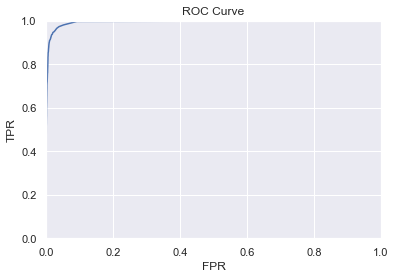

In [10]:
from sklearn.ensemble import BaggingClassifier

# fit random forest with bootstrap class weighting
m_rf_boo = RandomForestClassifier(class_weight = 'balanced_subsample', oob_score = True).fit(X_train, y_train)
y_pred = m_rf_boo.predict(X_test)

# calculate and plot ROC
y_pred_prob = m_rf_boo.predict_proba(X_test)[:, 1]
fp, tp, thresholds = metrics.roc_curve(y_test_bi, y_pred_prob)

plt.plot(fp, tp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

# report model scores
mat = confusion_matrix(y_test, m_rf.predict(X_test))
cm = pd.DataFrame(mat, index = ['Actual: NO', 'Actual: YES'], columns = ['Predicted: NO', 'Predicted: YES'])
print(cm,'\n')
print('test error:',m_rf_boo.score(X_test, y_test))
print('Missclassification:',1-metrics.accuracy_score(y_test, y_pred))
print('AUC:',metrics.roc_auc_score(y_test, y_pred_prob))
print('Out of Bag error:',m_rf_boo.oob_score_)

(e)

In [11]:
!pip install javabridge
!pip install python-weka-wrapper3

In [12]:
import weka.core.jvm as jvm

ModuleNotFoundError: No module named 'weka'

In [13]:
import javabridge

ModuleNotFoundError: No module named 'javabridge'

In [14]:
# unable to import javabridge and jmv for some reason

(f)

In [15]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 0)
X_res, y_res = sm.fit_resample(X_train, y_train)